In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from itertools import product

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

# Read in data

In [2]:
# Read in
df10 = pd.read_csv('../data/df10.csv')

In [3]:
# Create binary target
df10['y_bin'] = df10['y'].apply(lambda x: 1 if x >= 15 else 0)

In [4]:
# Inspect
df10

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y,y_bin
0,0.611402,0.720283,3.165168,0.372100,-0.360194,6.417779,A2,B3,C16,D1,-16.680112,0
1,-0.463374,-0.908280,3.046919,0.866590,0.949304,6.142320,A1,B2,C6,D3,-0.347247,0
2,-0.004264,-2.710478,3.629876,0.587660,-0.413790,7.196720,A2,B1,C10,D3,-13.192616,0
3,0.310406,-0.511657,3.269785,3.036609,-0.430169,6.363889,A2,B5,C33,D2,0.764504,0
4,-2.537362,0.594968,1.731083,0.616347,1.753629,3.273066,A1,B1,C6,D3,1.757865,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.786519,-0.053336,4.551310,0.503011,-0.332187,8.955659,A2,B4,C48,D2,-5.785166,0
9996,-3.341972,-0.603921,2.693938,-0.788320,-0.766215,5.303121,A1,B5,C24,D2,19.692702,1
9997,-0.409354,0.337466,3.140098,-1.672133,-0.235241,5.997826,A1,B1,C32,D3,-0.011697,0
9998,-2.129938,-0.588379,3.735092,-0.368141,1.876631,7.281910,A2,B1,C16,D3,-17.691367,0


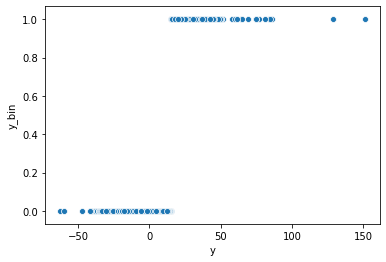

In [5]:
# Make sure this happened as expected
sb.scatterplot(df10.y, df10.y_bin)

In [6]:
# Check skew
df10.groupby('y_bin').agg(y_mean=('y', 'count'))

,y_mean
y_bin,
0,8935
1,1065


Moderate skew with ~10% 1, but 1k observations is probably enough relative observations to not have to worry about alternative procedures.  But good things to keep in mind:

- Downsampling, such reducing the number of 0s we have
- Upsampling, such as resampling our 1s to get a higher percentage

Note that this will affect our actual probability estimates (i.e. by artificially increasing the probability of 1), which sometimes doesn't matter (e.g. if you just want to rank observations) but sometimes does (e.g. if the probability is important).

# Fit a GBM

Borrowing code from previous work.

In [7]:
# Train/test/holdout vars
p_train = 0.6
p_test = 0.2
p_test_relative = p_test / (p_train + p_test)
p_holdout = 0.2
k_folds = 5

# Static hyperparameters
s_n_estimators = 1000
s_validation_fraction = 0.2
s_max_features = 'sqrt'
s_subsample = 0.67
s_n_iter_no_change = 1
s_tol = 1e-4

# Lists of hyperparameters to optimize
l_max_depth = [2, 3, 4, 5, 6, 7, 8]

In [8]:
# Add some x2 predictors
df10['x2_abs'] = abs(df10['x2'])
df10['x2_sign'] = np.sign(df10['x2'])

In [9]:
# Somewhat suboptimally, get x9 group means
predictors_1 = ['x1']
X, y = pd.get_dummies(df10[predictors_1]),  df10['y_bin']

# Split train/test/holdout
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=p_holdout, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=p_test_relative, random_state=2)

# Get x9 group means on training data
dict_x9_means = df10.iloc[X_train.index].groupby('x9').agg(y_mean=('y', 'mean'))['y_mean'].to_dict()
dict_x9_means

# Add some x2 predictors
df10['x9_group_mean'] = df10['x9'].map(dict_x9_means)

In [10]:
# Create train/test/holdout for reel

# Create X/y
predictors_1 = ['x1', 'x2', 'x2_abs', 'x2_sign', 'x4', 'x5', 'x7', 'x8', 'x9_group_mean', 'x10']
X, y = pd.get_dummies(df10[predictors_1], prefix=['x7', 'x8', 'x10']), df10['y_bin']

# Split train/test/holdout
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=p_holdout, random_state=1)

# Split train from train/test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=p_test_relative, random_state=2)

# Get x9 group means on training data
dict_x9_means = df10.iloc[X_train.index].groupby('x9').agg(y_mean=('y', 'mean'))['y_mean'].to_dict()
dict_x9_means

# Check counts
print(f'''
Train: {X_train.shape}
Test: {X_test.shape}
Holdout: {X_holdout.shape}
''')


Train: (6000, 17)
Test: (2000, 17)
Holdout: (2000, 17)



In [11]:
# Check sampling of y_bin across train/test/holdout
print(f'''
Train:
{y_train.value_counts()}

Test:
{y_test.value_counts()}

Holdout:
{y_holdout.value_counts()}
''')


Train:
0    5359
1     641
Name: y_bin, dtype: int64

Test:
0    1799
1     201
Name: y_bin, dtype: int64

Holdout:
0    1777
1     223
Name: y_bin, dtype: int64



~200 observations in test/holdout isn't a whole lot of observations, but we'll see how it goes.

In [12]:
# Inspect
X_train[:100]

,x1,x2,x2_abs,x2_sign,x4,x5,x9_group_mean,x7_A1,x7_A2,x8_B1,x8_B2,x8_B3,x8_B4,x8_B5,x10_D1,x10_D2,x10_D3
7820,-0.078334,0.115891,0.115891,1.0,-0.488403,-1.413578,7.075608,0,1,0,0,0,0,1,0,1,0
5815,-0.176155,-0.680363,0.680363,-1.0,-0.240706,0.175628,7.722661,0,1,0,0,0,1,0,0,1,0
7309,-0.162135,0.121755,0.121755,1.0,-0.340601,-0.265997,-2.611465,1,0,1,0,0,0,0,0,0,1
7163,1.169306,-0.884419,0.884419,-1.0,-1.188843,-0.672381,6.564165,1,0,0,1,0,0,0,0,0,1
2674,0.753028,0.484104,0.484104,1.0,2.197639,0.424596,1.085775,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7254,-0.687916,0.848593,0.848593,1.0,-1.133080,0.801421,-11.874919,0,1,0,1,0,0,0,0,0,1
6942,-0.333651,-0.428045,0.428045,-1.0,-0.699866,-0.492881,3.684532,1,0,0,0,1,0,0,1,0,0
7125,-0.978244,-2.198402,2.198402,-1.0,0.420133,-1.562900,-3.588966,1,0,1,0,0,0,0,0,0,1
9765,0.435193,0.863165,0.863165,1.0,-1.812185,-0.739455,7.075608,0,1,0,0,1,0,0,1,0,0


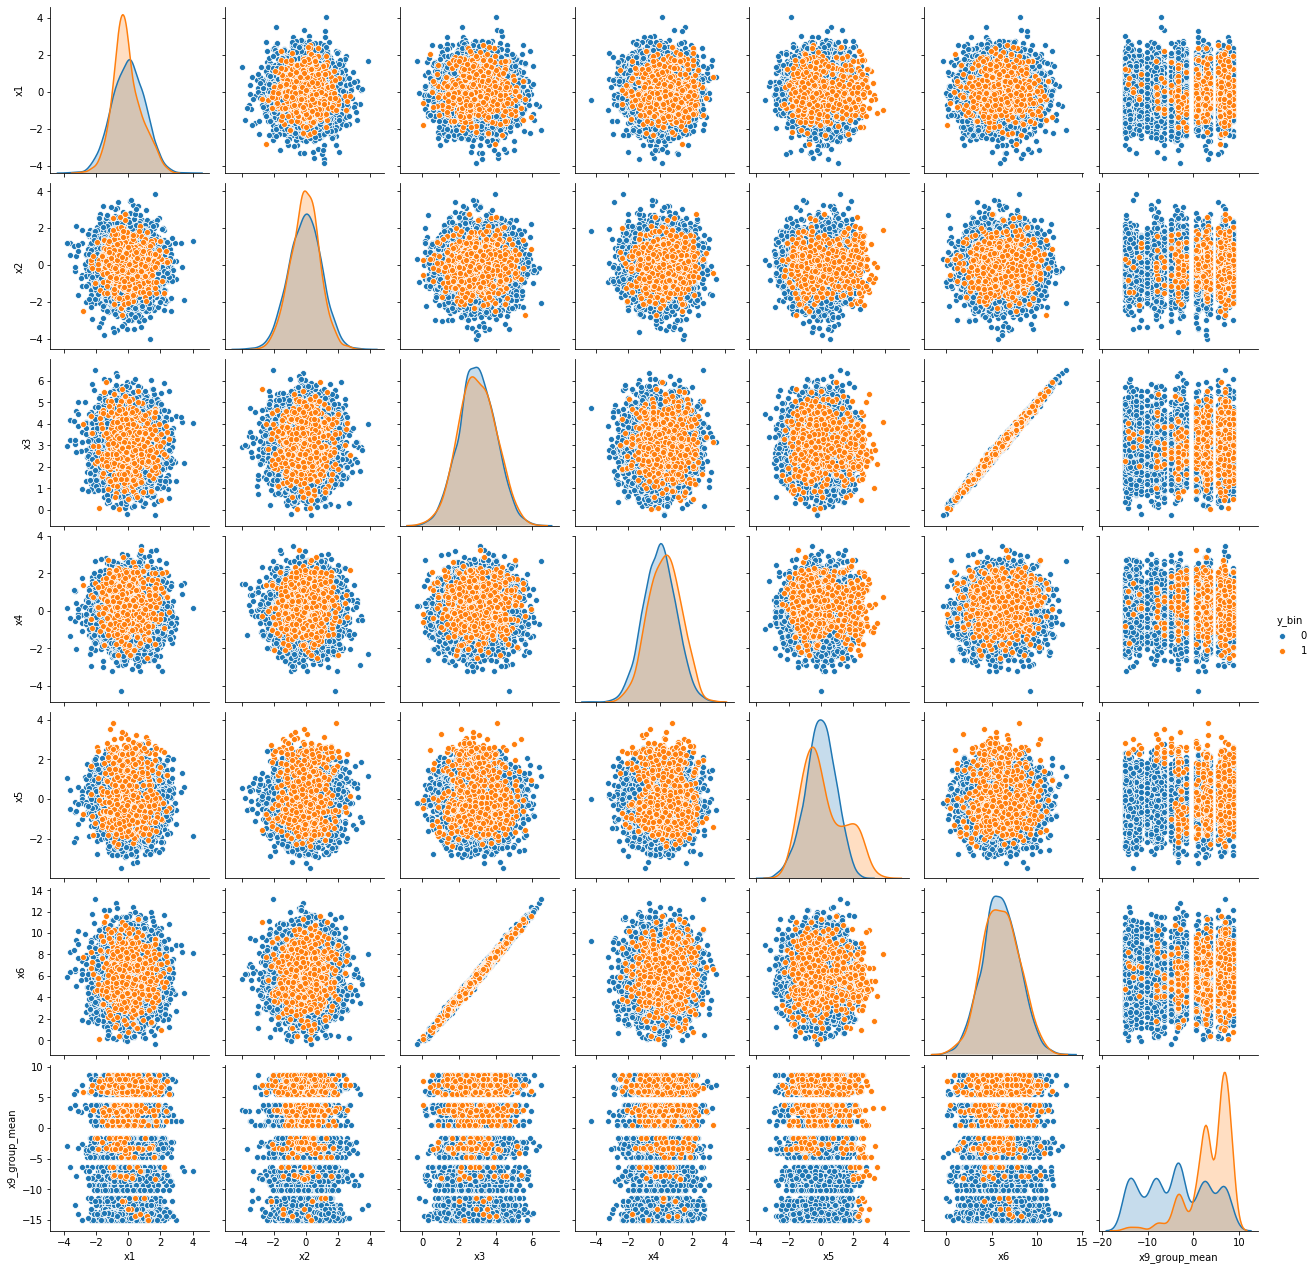

In [13]:
# Let's do a pairplot, coloring based on y_bin
sb.pairplot(
    (
        df10
        .iloc[X_train.index]
        .assign(y_bin = y_train)
        .drop(['y', 'x2_abs', 'x2_sign'], axis=1)
    ),
    hue='y_bin'
)

We definitely see some interaction relationships (e.g. x9 with mode things seems to help distinguish 0s from 1s, as does higher x5 values).

Also, it looks like some of the previously noted relationship (e.g. y ~ x5 being cubic) no longer matter.

In [14]:
# Set random seed for everything that follows
np.random.seed(666)

In [15]:
# Remind ourselves what loss functions are natively supported
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

With binary classification, there are roughly two "classes" of metrics:

- Metrics that evaluate the **probability**
- Metrics that evaluate the **classification** (i.e. 0 or 1)

Algorithms generally predict the probability of assignment (though some are exceptions, like support vector machines) and we have to be careful about which we want to work with.  In order to convert probabilities to classifications, we simply need to set a threshold such that predicted probabilities below that threshold get classified as 0 and otherwise get classified as 1.  If your algorithm is returning a 0/1 value, chances are it's using a threshold of 0.5.

Depending on which makes the most sense for your given use case, the best metrics to use will vary.  Some common metrics:

- Probability
    - Log loss, which penalizes the difference between the predicted probability and the actual outcome (and Derek mistakenly called "deviance" all the time, sorry about that)
    - AUC (Area Under the Curve), which is a measure of how well your data is ordered (i.e. how likely are 1s to have a higher predicted probability than 0s)
- Classification
    - Accuracy, which is the % of observations correctly classified
    - Precision, which is the ratio of true positives to all **predicted** positives (i.e. true positives and false positives)
    - Recall, which is the ratio of true positives to all **actual** positives (i.e. true positives and false negatives)
    - F1 score, which is the harmonic mean of precision and recall

##### Note: Deviance is actually used for fitting, scikit does not support using most accuracy measure as explicit splitting criteria

So for simplicity, let's start by trying to optimize for AUC and expand later on.

### Optimize for AUC

In [16]:
# Cross-validate
scores = []
for md in l_max_depth:
    # Print status
    print(f'Fitting max_depth={md}')
    
    # Initialize gbm
    gbm = GradientBoostingClassifier(
        # Static hyperparameters
        n_estimators = s_n_estimators,
        validation_fraction = s_validation_fraction,
        max_features = s_max_features,
        subsample = s_subsample,
        n_iter_no_change = s_n_iter_no_change,
        tol = s_tol,
        # Dynamic hyperparameters
        max_depth = md,
    )

    # Get scores
    cv_score = cross_val_score(
        gbm,
        X_train,
        y_train,
        cv = k_folds,
        scoring = 'roc_auc',
    ) 

    # Save the score means and standard deviations
    for i, k in enumerate(cv_score):
        scores += [(md, i, k, np.mean(cv_score))]
    
    del gbm, cv_score

Fitting max_depth=2
Fitting max_depth=3
Fitting max_depth=4
Fitting max_depth=5
Fitting max_depth=6
Fitting max_depth=7
Fitting max_depth=8


In [17]:
# Save results as a dataframe
scores_df = pd.DataFrame(
    scores,
    columns = ['max_depth', 'k', 'score_k', 'score_hp_mean']
)

# Order by score_hp_mean and k
scores_df = scores_df.sort_values(['max_depth', 'k']).reset_index()

scores_df.head(10)

,index,max_depth,k,score_k,score_hp_mean
0,0,2,0,0.987152,0.981724
1,1,2,1,0.979813,0.981724
2,2,2,2,0.984907,0.981724
3,3,2,3,0.972795,0.981724
4,4,2,4,0.983953,0.981724
5,5,3,0,0.988401,0.983647
6,6,3,1,0.985767,0.983647
7,7,3,2,0.981496,0.983647
8,8,3,3,0.981576,0.983647
9,9,3,4,0.980993,0.983647


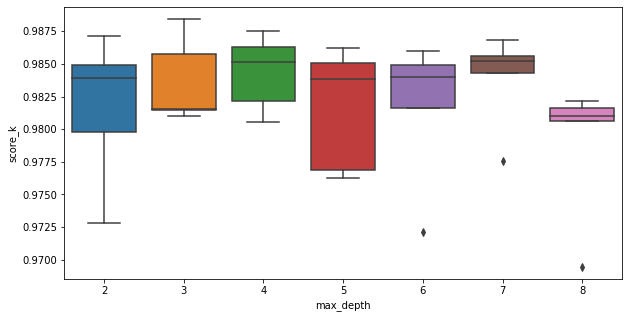

In [18]:
# Boxplot of performance for each parameter set
plt.figure(figsize=(10, 5))
sb.boxplot(
    data = scores_df,
    x = 'max_depth',
    y = 'score_k',
)

4, 6, and 7 perform fairly similar, but 6/7 have some outlying folds.

Let's refit all three and pick the one that does best on the test data.

In [19]:
model_depth4 = GradientBoostingClassifier(
    # Static hyperparameters
    n_estimators = s_n_estimators,
    validation_fraction = s_validation_fraction,
    max_features = s_max_features,
    subsample = s_subsample,
    n_iter_no_change = s_n_iter_no_change,
    tol = s_tol,
    # Dynamic hyperparameters
    max_depth = 4,
    # Print status
    verbose = 1
).fit(X_train, y_train)

model_depth6 = GradientBoostingClassifier(
    # Static hyperparameters
    n_estimators = s_n_estimators,
    validation_fraction = s_validation_fraction,
    max_features = s_max_features,
    subsample = s_subsample,
    n_iter_no_change = s_n_iter_no_change,
    tol = s_tol,
    # Dynamic hyperparameters
    max_depth = 6,
    # Print status
    verbose = 1
).fit(X_train, y_train)

model_depth7 = GradientBoostingClassifier(
    # Static hyperparameters
    n_estimators = s_n_estimators,
    validation_fraction = s_validation_fraction,
    max_features = s_max_features,
    subsample = s_subsample,
    n_iter_no_change = s_n_iter_no_change,
    tol = s_tol,
    # Dynamic hyperparameters
    max_depth = 7,
    # Print status
    verbose = 1
).fit(X_train, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.6432           0.0389            4.00s
         2           0.6236           0.0201            4.49s
         3           0.6027           0.0234            4.32s
         4           0.5591           0.0259            4.23s
         5           0.5401           0.0220            4.38s
         6           0.4864           0.0306            4.31s
         7           0.4692           0.0345            4.26s
         8           0.4288           0.0265            4.34s
         9           0.4213           0.0124            4.29s
        10           0.4120           0.0050            4.26s
        20           0.2841           0.0069            4.07s
        30           0.2338           0.0024            4.01s
        40           0.2032           0.0019            3.94s
        50           0.1728           0.0008            3.86s
        60           0.1604           0.0017            3.82s
      I

In [20]:
# One important note about predict_proba: it returns the probability for each class ordered by label (i.e 0 comes first)
model_depth4.predict_proba(X_test)

array([[9.83723005e-01, 1.62769949e-02],
       [9.87117671e-01, 1.28823291e-02],
       [9.43508584e-01, 5.64914158e-02],
       ...,
       [8.19197364e-01, 1.80802636e-01],
       [9.99150918e-01, 8.49082183e-04],
       [9.43384058e-01, 5.66159417e-02]])

In [21]:
# We just want the second value, i.e. the probability of being 1
[x[1] for x in model_depth4.predict_proba(X_test)][:5]

[0.016276994942917886,
 0.012882329087402835,
 0.056491415826431586,
 0.0041806986944476834,
 0.0019868369299820623]

In [22]:
# Compare test AUC for each model
def get_test_auc(model):
    probs = [x[1] for x in model.predict_proba(X_test)]
    return roc_auc_score(y_test, probs)

print(f'''
Depth 4: {get_test_auc(model_depth4)}
Depth 6: {get_test_auc(model_depth6)}
Depth 7: {get_test_auc(model_depth7)}
''')


Depth 4: 0.9901133576143739
Depth 6: 0.9894358114928414
Depth 7: 0.9894745284140719



This are really high and frankly unrealistic AUCs in the real world!

AUC has meaningful interpretation: It is the probability that a randomly selected 1 has a higher prediction than a randomly selected 0 and hence gives a measure of separation between 0s and 1s in terms of their predicted probabilities.  Here, we have almost perfect separation.

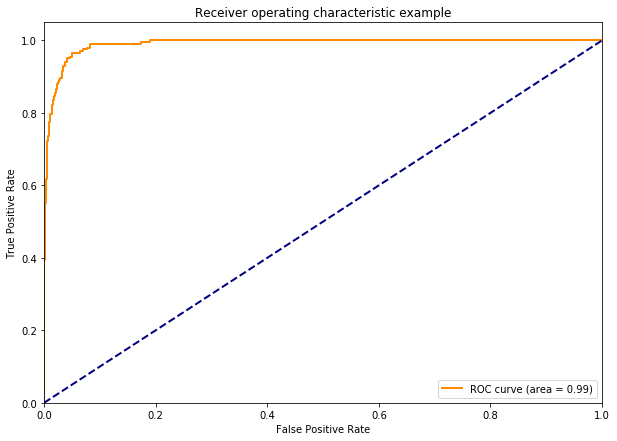

In [23]:
# Let's visualize an ROC curve
fpr, tpr, _ = roc_curve(y_test, [x[1] for x in model_depth4.predict_proba(X_test)])

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % get_test_auc(model_depth4))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

When working with probabilities, **calibration** is something you can look into as well.  A model is well-calibrated if the overall "actual rate" is similar to the overall "predicted rate".

As a concrete example, if we were predicting likelihood to contract a disease that has an "actual rate" of 20% then we would expect our overall "predicted rate" to also be around 20%.  This is generally done on the raw probability estimates as opposed to thresholded binary values in order to appropriately account for summing up expectations.

Say we had 3 observations with the following actuals and predicted probabilites:

- 0, 0.33
- 1, 0.33
- 1, 0.33

Our overall rates would then be:

- Actual: 0+1+1 = 2
- Predicted: 0.33+0.33+0.33 = 1

So overall we predict half of the average value that we should, and at least in this arbitrary example our model doesn't seem very calibrated (but the definition of good/bad calibration is very dependent on the use case).

Let's plot a "calibration curve" for each of our models:

- x-axis: Predicted probability
- y-axis: Actual probability

For simplicity, we'll bin observations by their predictions into the following groups:

-   0 - 0.2
- 0.2 - 0.4
- 0.4 - 0.6
- 0.6 - 0.8
- 0.8 - 1.0

In [24]:
def bin_pred(df, model):
    df = df.assign(p = [x[1] for x in model.predict_proba(X_test)])
    
    # Bin probabilities
    df['p_bin'] = pd.cut(df['p'], [0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # Add actuals
    df['y_bin'] = y_test
    
    # Aggregate
    df_agg = (
        df
        .groupby('p_bin')
        .agg(
            n=('y_bin', 'count'),
            y_sum=('y_bin', 'sum'),
        )
        .reset_index()
    )
    
    # Create a "continuous" p_bin using the middle of the bin
    df_agg['p_bin_cont'] = [0.1, 0.3, 0.5, 0.7, 0.9]
    
    # Create observed proportion
    df_agg['y_rate'] = df_agg['y_sum'] / df_agg['n']
    
    return df_agg

# Double check that I didn't do anything stupid with binning
assert bin_pred(X_test, model_depth4)['n'].sum() == X_test.shape[0]

# See what one looks like
bin_pred(X_test, model_depth4)

,p_bin,n,y_sum,p_bin_cont,y_rate
0,"(0.0, 0.2]",1735,11,0.1,0.006340
1,"(0.2, 0.4]",82,30,0.3,0.365854
2,"(0.4, 0.6]",46,32,0.5,0.695652
3,"(0.6, 0.8]",61,52,0.7,0.852459
4,"(0.8, 1.0]",76,76,0.9,1.000000


Notice that heavy skew towards < 0.2 predicted probability!

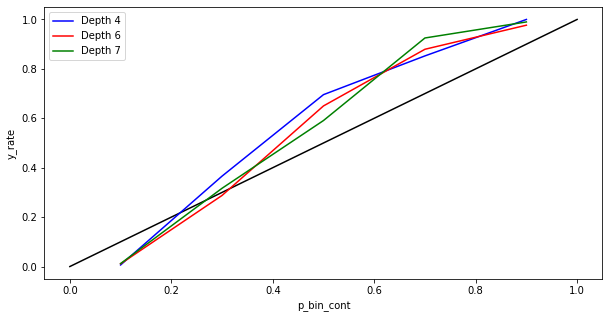

In [25]:
# Plot
plt.figure(figsize=(10, 5))

# Add "Ideal" line, i.e. our overall predicted risk is the same as our overall observed risk, or y=x
sb.lineplot(x=[0, 1], y=[0, 1], color='black')

# Add lines
sb.lineplot(
    data=bin_pred(X_test, model_depth4),
    x='p_bin_cont',
    y='y_rate',
    label='Depth 4',
    color='blue',
)
sb.lineplot(
    data=bin_pred(X_test, model_depth6),
    x='p_bin_cont',
    y='y_rate',
    label='Depth 6',
    color='red',
)
sb.lineplot(
    data=bin_pred(X_test, model_depth7),
    x='p_bin_cont',
    y='y_rate',
    label='Depth 7',
    color='green',
)


Overall, it looks like these models are somewhat calibrated:

- In the lowest bin, 0-0.2, we have an incredibly low actual rate so a high proportion of actual 0s must be here.  It does look lower than expected, but this is possibly because of our binning.  Given our high skew towards 0, we're likely doing a good job of giving these probabilities near 0.
- For the next lowest bin, 0.2-0.4, green/red are well-calibrated but blue is a bit off.
- For every other bin, we have a slightly higher actual rate than predicted rate.  Which suggests we're actually **underestimating** these probabilities because sum(actual) > sum(predicted)

Whenever possibly, it's actually preferable to do a more continuous-style callibration because binning can notably affect how calibrated our model seems to be.  Here, doing so would be difficult because of our heavy skew towards 0.

It's hard to declare a firm "winner" from this graph because our arbitrary binning is likely having an affect on how the graph looks.  Let's go with Depth 4 since it had the best AUC by a slight margin.

In [26]:
# Let's do some univariates
def plot_univariate(df, x, y, model_fit, n_bins=10):
    # Add prediction
    df = df.assign(p = [x[1] for x in model_fit.predict_proba(X_test)])
    
    # If x is numeric, bin into 5 groups
    if df[x].dtype in (np.int64, np.float64):
        df[x] = pd.cut(df[x], n_bins).apply(str)
    
    # Aggregate
    df_agg = (
        df
        .groupby(x)
        .agg(
            n=(y, 'count'),
            y_mean=(y, 'mean'),
            y_sd=(y, 'std'),
            p_mean=('p', 'mean'),
            p_sd=('p', 'std'),
        )
        .reset_index()
    )
    
    print(df_agg)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 10))
    
    # First plot: Counts
    ax1.bar(x, 'n', data=df_agg)
    
    # Second plot: Average actuals and predicted
    ax2.errorbar(x, 'y_mean', yerr='y_sd', data=df_agg, label='Actual', fmt='o', capsize=10, color='green')
    ax2.errorbar(x, 'p_mean', yerr='p_sd', data=df_agg, label='Predicted', fmt='o', capsize=10, color='red')
    
    plt.legend()
    plt.show()

                 x1    n    y_mean      y_sd    p_mean      p_sd
0  (-3.349, -2.656]   14  0.071429  0.267261  0.065879  0.212134
1  (-2.656, -1.971]   40  0.025000  0.158114  0.044749  0.120472
2  (-1.971, -1.285]  121  0.099174  0.300138  0.105259  0.219485
3  (-1.285, -0.599]  361  0.127424  0.333910  0.112255  0.241691
4  (-0.599, 0.0864]  531  0.148776  0.356203  0.128713  0.259687
5   (0.0864, 0.772]  479  0.056367  0.230871  0.061700  0.166214
6    (0.772, 1.458]  303  0.066007  0.248704  0.067230  0.175714
7    (1.458, 2.143]  114  0.105263  0.308247  0.099325  0.223441
8    (2.143, 2.829]   32  0.062500  0.245935  0.071925  0.165992
9    (2.829, 3.515]    5  0.200000  0.447214  0.172045  0.198990


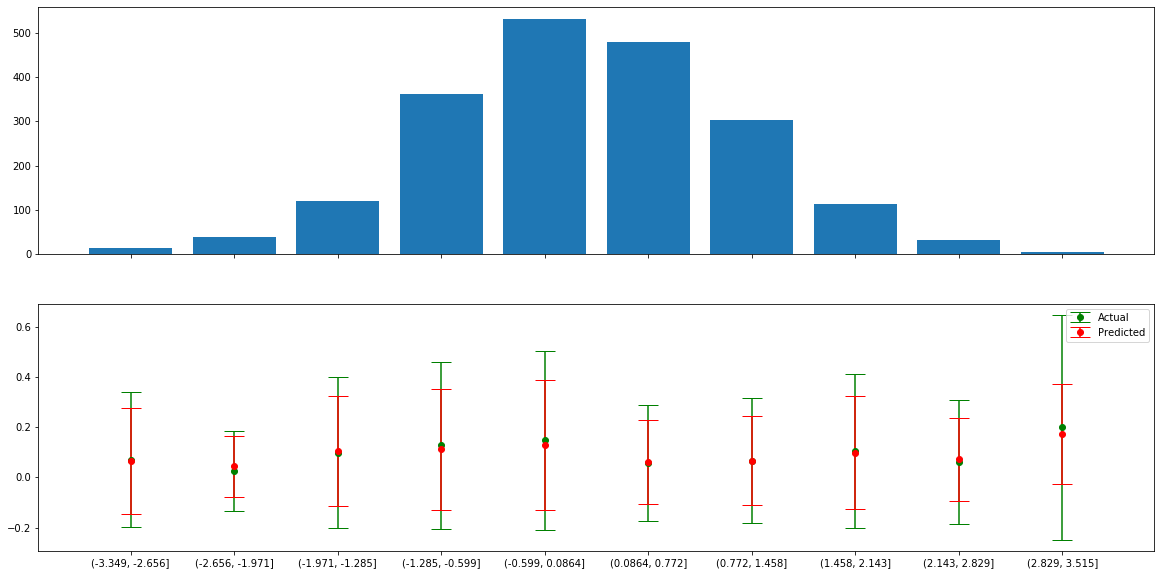

In [27]:
# x1
plot_univariate(df10.iloc[X_test.index], 'x1', 'y_bin', model_fit=model_depth4)

                 x2    n    y_mean      y_sd    p_mean      p_sd
0  (-3.279, -2.595]   11  0.000000  0.000000  0.019884  0.054659
1  (-2.595, -1.917]   51  0.039216  0.196039  0.054940  0.155829
2   (-1.917, -1.24]  148  0.081081  0.273886  0.083836  0.206756
3   (-1.24, -0.562]  324  0.129630  0.336415  0.111004  0.235870
4   (-0.562, 0.115]  516  0.108527  0.311347  0.104130  0.235253
5    (0.115, 0.793]  502  0.099602  0.299767  0.098579  0.220524
6    (0.793, 1.471]  308  0.110390  0.313885  0.087900  0.209171
7    (1.471, 2.148]  105  0.028571  0.167398  0.052580  0.129177
8    (2.148, 2.826]   29  0.034483  0.185695  0.016758  0.044576
9    (2.826, 3.503]    6  0.166667  0.408248  0.172970  0.217707


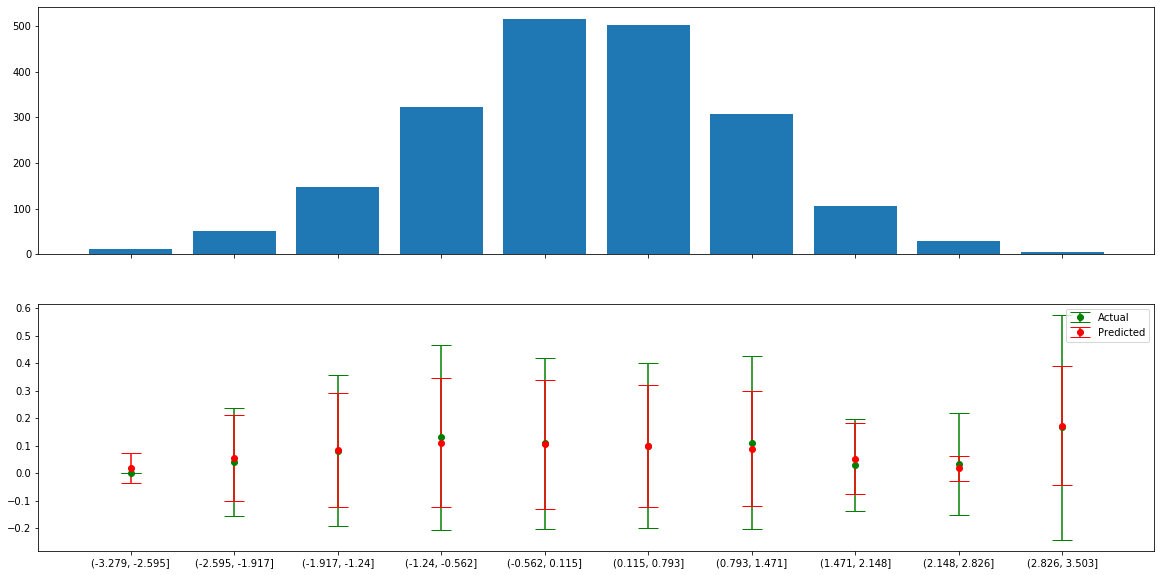

In [28]:
# x2
plot_univariate(df10.iloc[X_test.index], 'x2', 'y_bin', model_fit=model_depth4)

                x3    n    y_mean      y_sd    p_mean      p_sd
0  (-0.323, 0.366]    9  0.000000  0.000000  0.012298  0.016927
1   (0.366, 1.048]   43  0.186047  0.393750  0.174612  0.302244
2    (1.048, 1.73]  165  0.072727  0.260479  0.078772  0.190089
3    (1.73, 2.412]  362  0.118785  0.323983  0.112438  0.241593
4   (2.412, 3.094]  530  0.086792  0.281797  0.084243  0.202951
5   (3.094, 3.776]  462  0.101732  0.302623  0.089980  0.214587
6   (3.776, 4.458]  288  0.107639  0.310463  0.093325  0.212681
7    (4.458, 5.14]  113  0.115044  0.320497  0.110828  0.241973
8    (5.14, 5.822]   25  0.040000  0.200000  0.066675  0.146873
9   (5.822, 6.504]    3  0.000000  0.000000  0.040820  0.067424


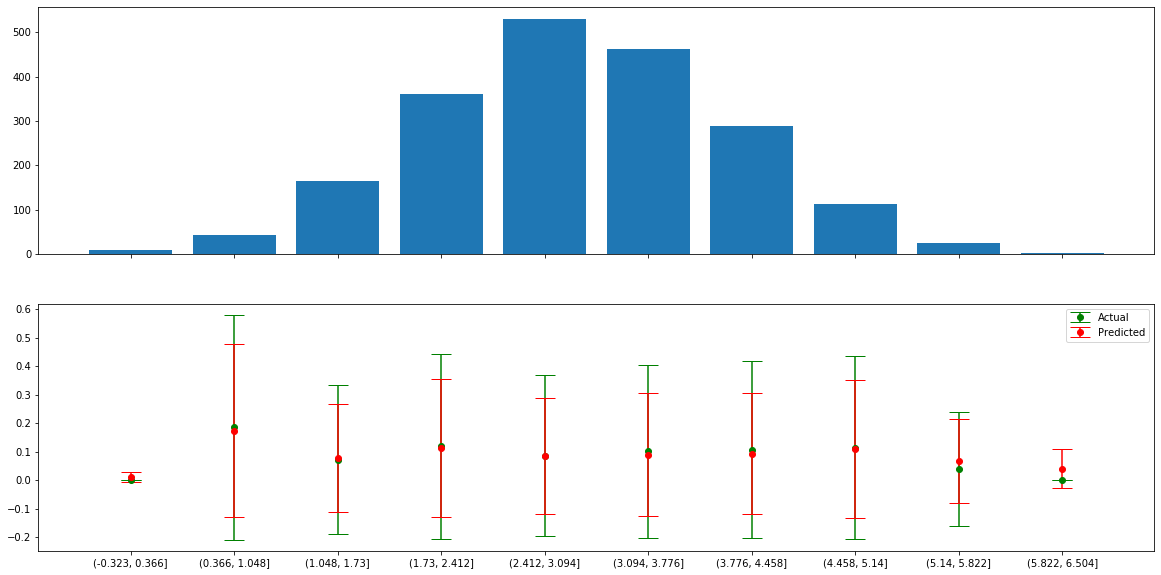

In [29]:
# x2
plot_univariate(df10.iloc[X_test.index], 'x3', 'y_bin', model_fit=model_depth4)

                 x4    n    y_mean      y_sd    p_mean      p_sd
0  (-3.336, -2.646]    6  0.000000  0.000000  0.009911  0.016712
1  (-2.646, -1.964]   37  0.054054  0.229243  0.050780  0.144886
2  (-1.964, -1.281]  136  0.044118  0.206116  0.052671  0.142504
3  (-1.281, -0.598]  358  0.094972  0.293587  0.090924  0.211353
4  (-0.598, 0.0847]  511  0.078278  0.268872  0.077032  0.187326
5   (0.0847, 0.767]  508  0.124016  0.329924  0.113118  0.246833
6     (0.767, 1.45]  305  0.127869  0.334493  0.114637  0.238702
7     (1.45, 2.133]  108  0.120370  0.326911  0.108023  0.238260
8    (2.133, 2.816]   23  0.130435  0.344350  0.131189  0.284569
9    (2.816, 3.499]    8  0.125000  0.353553  0.075188  0.193415


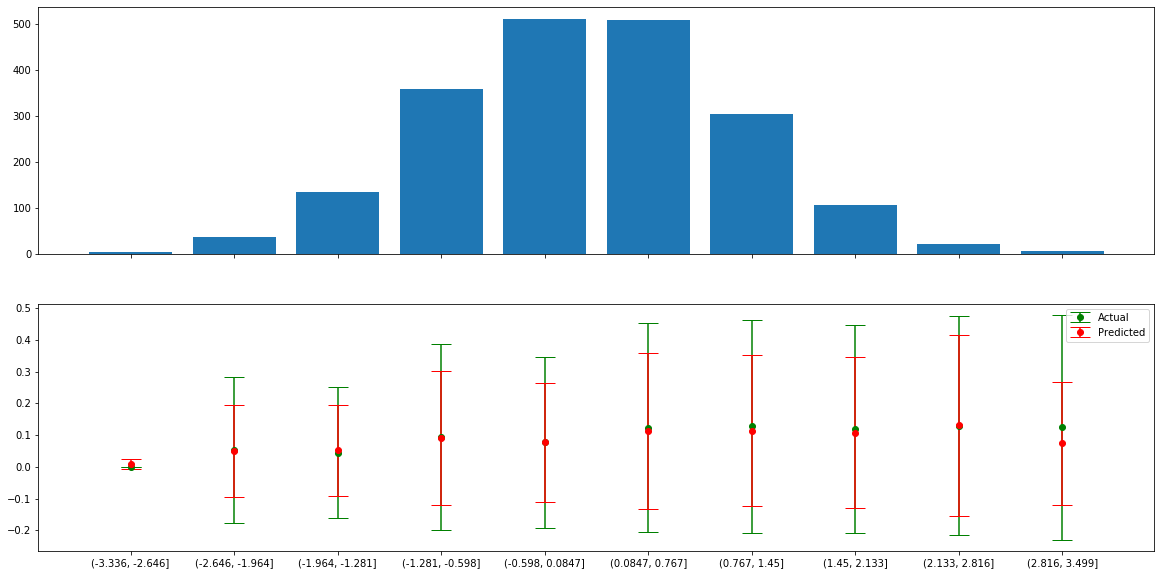

In [30]:
# x4
plot_univariate(df10.iloc[X_test.index], 'x4', 'y_bin', model_fit=model_depth4)

                 x5    n    y_mean      y_sd    p_mean      p_sd
0  (-3.852, -3.123]    2  0.000000  0.000000  0.015359  0.019685
1  (-3.123, -2.402]   19  0.052632  0.229416  0.063004  0.198709
2   (-2.402, -1.68]   89  0.056180  0.231573  0.074830  0.193319
3   (-1.68, -0.958]  215  0.134884  0.342397  0.099708  0.222663
4  (-0.958, -0.236]  502  0.109562  0.312654  0.090353  0.214639
5   (-0.236, 0.486]  558  0.051971  0.222168  0.075735  0.188510
6    (0.486, 1.207]  394  0.071066  0.257262  0.079612  0.198000
7    (1.207, 1.929]  177  0.146893  0.355003  0.110237  0.239721
8    (1.929, 2.651]   36  0.555556  0.503953  0.396936  0.312021
9    (2.651, 3.373]    8  1.000000  0.000000  0.827253  0.134948


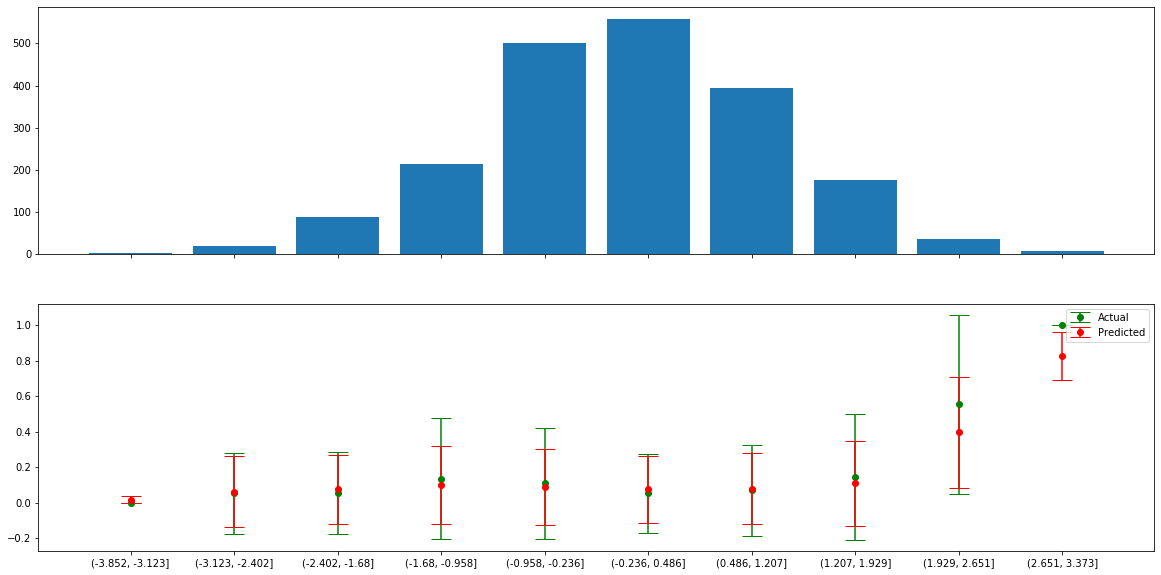

In [31]:
# x5
plot_univariate(df10.iloc[X_test.index], 'x5', 'y_bin', model_fit=model_depth4)

                 x6    n    y_mean      y_sd    p_mean      p_sd
0   (-0.968, 0.459]    6  0.000000  0.000000  0.004578  0.004267
1    (0.459, 1.871]   34  0.205882  0.410426  0.201935  0.308893
2    (1.871, 3.284]  146  0.068493  0.253460  0.078023  0.194418
3    (3.284, 4.697]  358  0.111732  0.315477  0.106832  0.236247
4    (4.697, 6.109]  523  0.095602  0.294327  0.091152  0.210045
5    (6.109, 7.522]  494  0.095142  0.293708  0.083606  0.207105
6    (7.522, 8.934]  298  0.107383  0.310120  0.093883  0.215743
7   (8.934, 10.347]  114  0.122807  0.329665  0.119279  0.244614
8  (10.347, 11.759]   24  0.041667  0.204124  0.063663  0.148994
9  (11.759, 13.172]    3  0.000000  0.000000  0.040793  0.067447


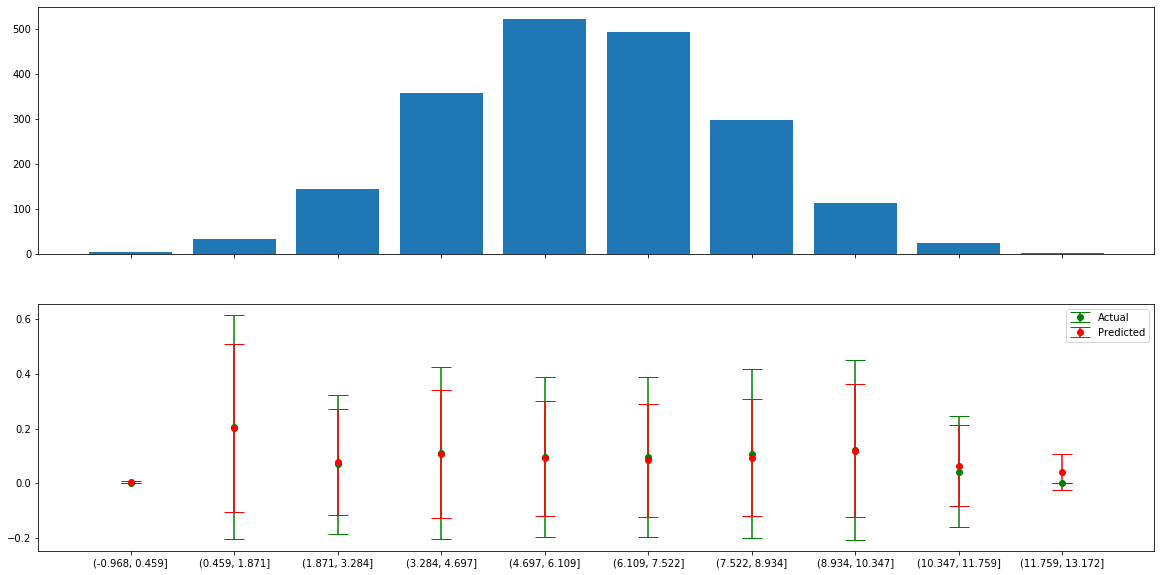

In [32]:
# x6
plot_univariate(df10.iloc[X_test.index], 'x6', 'y_bin', model_fit=model_depth4)

   x7     n    y_mean      y_sd    p_mean     p_sd
0  A1   931  0.204082  0.403246  0.189388  0.28313
1  A2  1069  0.010290  0.100964  0.011608  0.06314


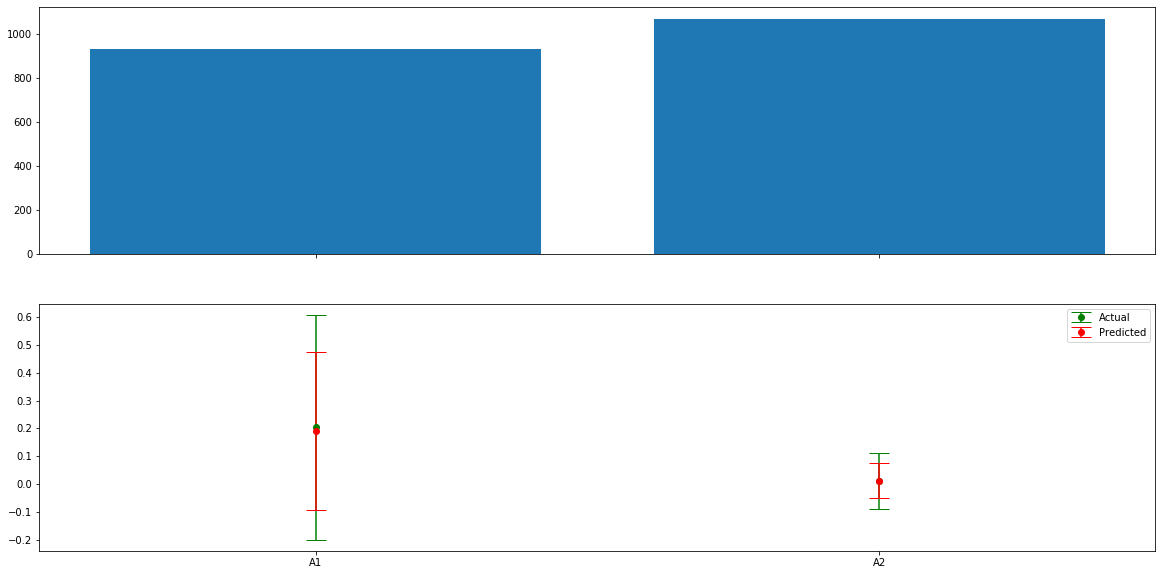

In [33]:
# x7
plot_univariate(df10.iloc[X_test.index], 'x7', 'y_bin', model_fit=model_depth4)

   x8    n    y_mean      y_sd    p_mean      p_sd
0  B1  408  0.041667  0.200072  0.033793  0.099489
1  B2  384  0.031250  0.174220  0.031521  0.101284
2  B3  439  0.157175  0.364381  0.144217  0.271566
3  B4  365  0.128767  0.335402  0.125421  0.247018
4  B5  404  0.138614  0.345972  0.133038  0.258869


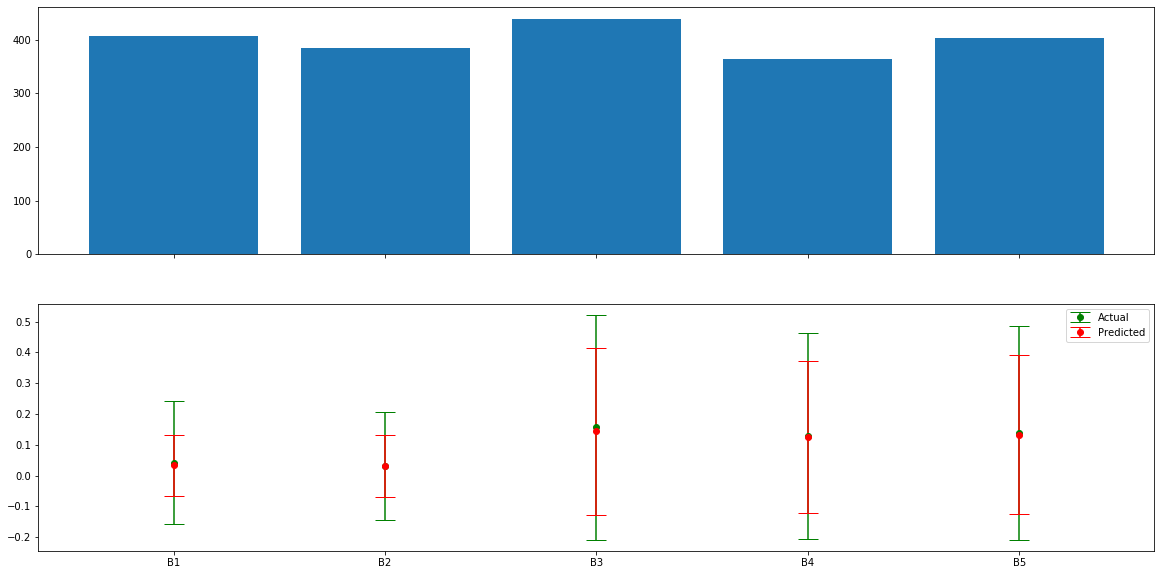

In [34]:
# x8
plot_univariate(df10.iloc[X_test.index], 'x8', 'y_bin', model_fit=model_depth4)

                 x6    n    y_mean      y_sd    p_mean      p_sd
0   (-0.968, 0.459]    6  0.000000  0.000000  0.004578  0.004267
1    (0.459, 1.871]   34  0.205882  0.410426  0.201935  0.308893
2    (1.871, 3.284]  146  0.068493  0.253460  0.078023  0.194418
3    (3.284, 4.697]  358  0.111732  0.315477  0.106832  0.236247
4    (4.697, 6.109]  523  0.095602  0.294327  0.091152  0.210045
5    (6.109, 7.522]  494  0.095142  0.293708  0.083606  0.207105
6    (7.522, 8.934]  298  0.107383  0.310120  0.093883  0.215743
7   (8.934, 10.347]  114  0.122807  0.329665  0.119279  0.244614
8  (10.347, 11.759]   24  0.041667  0.204124  0.063663  0.148994
9  (11.759, 13.172]    3  0.000000  0.000000  0.040793  0.067447


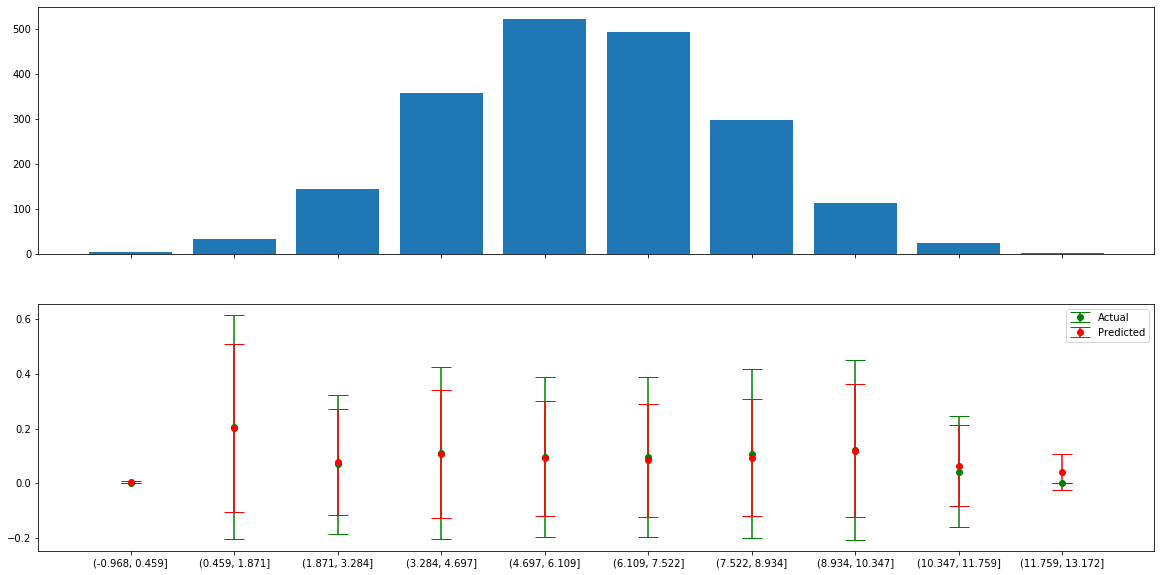

In [35]:
# x8
plot_univariate(df10.iloc[X_test.index], 'x6', 'y_bin', model_fit=model_depth4)

     x9   n    y_mean      y_sd    p_mean      p_sd
0    C0  44  0.000000  0.000000  0.009370  0.013873
1    C1  39  0.000000  0.000000  0.010285  0.014121
2   C10  41  0.024390  0.156174  0.028715  0.089458
3   C11  41  0.000000  0.000000  0.010656  0.012984
4   C12  42  0.047619  0.215540  0.022786  0.052937
5   C13  48  0.104167  0.308709  0.136760  0.257235
6   C14  44  0.250000  0.438019  0.215396  0.321566
7   C15  43  0.046512  0.213083  0.024804  0.088024
8   C16  47  0.000000  0.000000  0.007481  0.008555
9   C17  47  0.042553  0.204030  0.045741  0.139453
10  C18  51  0.078431  0.271524  0.085241  0.176518
11  C19  35  0.342857  0.481594  0.292664  0.374305
12   C2  34  0.058824  0.238833  0.028854  0.043875
13  C20  40  0.025000  0.158114  0.025351  0.088242
14  C21  34  0.000000  0.000000  0.026249  0.083049
15  C22  30  0.000000  0.000000  0.009886  0.015435
16  C23  25  0.080000  0.276887  0.129578  0.255649
17  C24  42  0.238095  0.431081  0.232653  0.337908
18  C25  32 

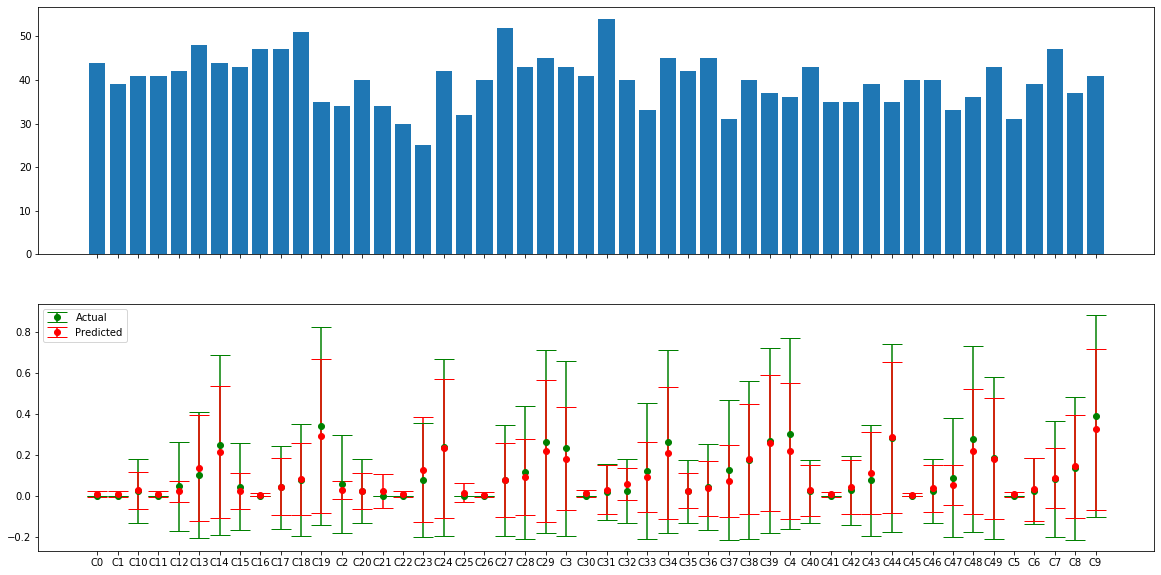

In [36]:
# x9
plot_univariate(df10.iloc[X_test.index], 'x9', 'y_bin', model_fit=model_depth4)

  x10    n    y_mean      y_sd    p_mean      p_sd
0  D1  421  0.154394  0.361756  0.143771  0.272454
1  D2  826  0.129540  0.336000  0.125774  0.248918
2  D3  753  0.038513  0.192558  0.032287  0.099856


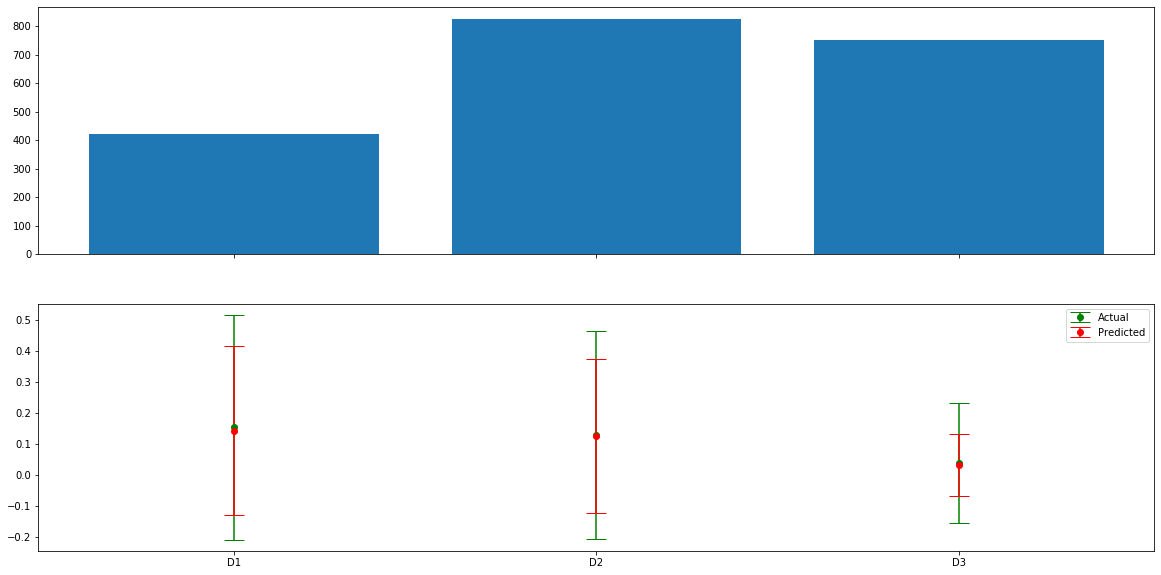

In [37]:
# x10
plot_univariate(df10.iloc[X_test.index], 'x10', 'y_bin', model_fit=model_depth4)

As you hopefully noticed, we might need to be a bit more careful interpreting these errors bars for a binary variable since probabilities can't be negative!

But we'll gloss over that for now.

### Now let's see what max_depth is optimal in terms of accuracy

In scikit, Derek is fairly confident that thresholding will automatically apply at 0.5.

In [38]:
# Cross-validate
scores = []
for md in l_max_depth:
    # Print status
    print(f'Fitting max_depth={md}')
    
    # Initialize gbm
    gbm = GradientBoostingClassifier(
        # Static hyperparameters
        n_estimators = s_n_estimators,
        validation_fraction = s_validation_fraction,
        max_features = s_max_features,
        subsample = s_subsample,
        n_iter_no_change = s_n_iter_no_change,
        tol = s_tol,
        # Dynamic hyperparameters
        max_depth = md,
    )

    # Get scores
    cv_score = cross_val_score(
        gbm,
        X_train,
        y_train,
        cv = k_folds,
        scoring = 'accuracy',
    ) 

    # Save the score means and standard deviations
    for i, k in enumerate(cv_score):
        scores += [(md, i, k, np.mean(cv_score))]
    
    del gbm, cv_score

Fitting max_depth=2
Fitting max_depth=3
Fitting max_depth=4
Fitting max_depth=5
Fitting max_depth=6
Fitting max_depth=7
Fitting max_depth=8


In [39]:
# Save results as a dataframe
scores_df = pd.DataFrame(
    scores,
    columns = ['max_depth', 'k', 'score_k', 'score_hp_mean']
)

# Order by score_hp_mean and k
scores_df = scores_df.sort_values(['max_depth', 'k']).reset_index()

scores_df.head(10)

,index,max_depth,k,score_k,score_hp_mean
0,0,2,0,0.945000,0.952667
1,1,2,1,0.950833,0.952667
2,2,2,2,0.953333,0.952667
3,3,2,3,0.962500,0.952667
4,4,2,4,0.951667,0.952667
5,5,3,0,0.962500,0.959833
6,6,3,1,0.955000,0.959833
7,7,3,2,0.962500,0.959833
8,8,3,3,0.956667,0.959833
9,9,3,4,0.962500,0.959833


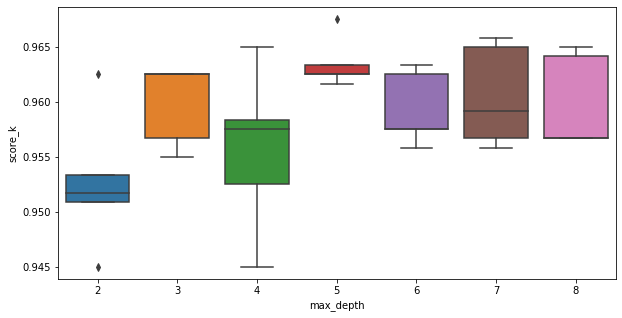

In [40]:
# Boxplot of performance for each parameter set
plt.figure(figsize=(10, 5))
sb.boxplot(
    data = scores_df,
    x = 'max_depth',
    y = 'score_k',
)

Oh wow, 5 definitely looks the best and consistently for all 5 folds.  And 4, one the best in terms of AUC, looks like the second worse overall.

### Let's test one more common metric: f1 score

In [41]:
# Cross-validate
scores = []
for md in l_max_depth:
    # Print status
    print(f'Fitting max_depth={md}')
    
    # Initialize gbm
    gbm = GradientBoostingClassifier(
        # Static hyperparameters
        n_estimators = s_n_estimators,
        validation_fraction = s_validation_fraction,
        max_features = s_max_features,
        subsample = s_subsample,
        n_iter_no_change = s_n_iter_no_change,
        tol = s_tol,
        # Dynamic hyperparameters
        max_depth = md,
    )

    # Get scores
    cv_score = cross_val_score(
        gbm,
        X_train,
        y_train,
        cv = k_folds,
        scoring = 'f1',
    ) 

    # Save the score means and standard deviations
    for i, k in enumerate(cv_score):
        scores += [(md, i, k, np.mean(cv_score))]
    
    del gbm, cv_score

Fitting max_depth=2
Fitting max_depth=3
Fitting max_depth=4
Fitting max_depth=5
Fitting max_depth=6
Fitting max_depth=7
Fitting max_depth=8


In [42]:
# Save results as a dataframe
scores_df = pd.DataFrame(
    scores,
    columns = ['max_depth', 'k', 'score_k', 'score_hp_mean']
)

# Order by score_hp_mean and k
scores_df = scores_df.sort_values(['max_depth', 'k']).reset_index()

scores_df.head(10)

,index,max_depth,k,score_k,score_hp_mean
0,0,2,0,0.810573,0.758445
1,1,2,1,0.755365,0.758445
2,2,2,2,0.707547,0.758445
3,3,2,3,0.723982,0.758445
4,4,2,4,0.794760,0.758445
5,5,3,0,0.813559,0.744019
6,6,3,1,0.782979,0.744019
7,7,3,2,0.764444,0.744019
8,8,3,3,0.632653,0.744019
9,9,3,4,0.726457,0.744019


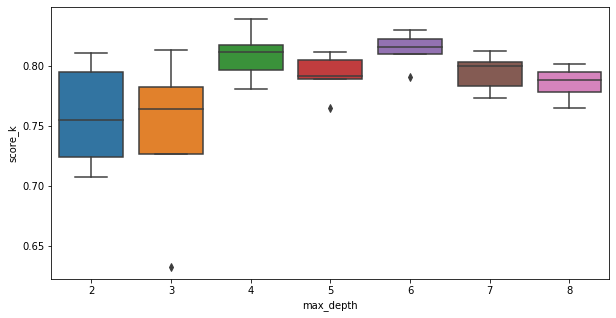

In [43]:
# Boxplot of performance for each parameter set
plt.figure(figsize=(10, 5))
sb.boxplot(
    data = scores_df,
    x = 'max_depth',
    y = 'score_k',
)

Looks to be similar to the other two, with 6 seeming like the best on average.

At this point a few things stick out:

- You will very likely select different models depending on what you optimize for, so it's important to pick the objection criteria (standard or custom!) that best addresses the question at hand.  Some examples of things to keep in mind:
    - AUC is an **ordering** metric and doesn't really care what the probabilities.  Which is fine if you, say, just want to isolate the most likely *n* observations to have something but possibly very misleading if you need to use those probabilities for any sort calculate (which is why I like to look at calibration in addition to AUC.
    - When analyzing accuracy or accuracy-like measures like precision, recall, and f1 score it's important to be careful about:
        - Thresholding, because it can have a huge impact on your numbers, and especially if probability predictions are near the threshold.
        - How things like data skew can impact your results, such as imbalanced data giving an unrealistic estimate of how well the model is doing.  For example, if we have 99% 0s and 1% 1s, our accuracy will look incredible even if we just predict 0s for everything!
    - Depending on the application, false positives and false negatives can have very different costs and can help us decide the best objective criteria
        - For example, if we were predicting the likelihood of a transaction being fraudulent then the "cost" of a false negative (i.e. not predicting fraud when it is) could mean losing that entire transaction whereas a false positive (i.e. predict fraud when it is not) is harder to estimate in terms of cost (e.g. salary time spent following up on it, lost future transactions from that customer).
        - On the flip side, it is sometimes very difficult to estimate the cost of getting a prediction wrong in either

When dealing with even mild skew, it is usually worth trying some other techniques like upsampling and downsampling to try to mitigate the effect of skew but you need to careful about postprocessing the model iof 

I purposely didn't look at the holdout here set in case we wanted to do that later.